# Better Visualization of NEK 9 Dataset
## Chongye Feng

-------
### Importing Necessary Libraries

In [23]:
# Basic libraries for data manipulation and mathematical operations
import math
import numpy as np
import pandas as pd
import torch

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Machine Learning and Data Preprocessing
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

# Handling imbalanced datasets
import imblearn
from imblearn.over_sampling import SMOTE
print("imblearn version: ", imblearn.__version__)

# Visualization libraries
import seaborn as sns
import matplotlib 
matplotlib.use('Agg')  # Necessary for environments without a display (e.g., server)
from matplotlib import pyplot as plt
%matplotlib inline

# Gaussian Process for Machine Learning (GPML)
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# Dimensionality Reduction for Visualization
from sklearn.manifold import TSNE

# Miscellaneous
import os

# Jupyter Notebook specific commands for autoreloading modules
%load_ext autoreload
%autoreload 2

imblearn version:  0.11.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


------

### Some Functions for Visualization

In [8]:
from VisUtils import plot_confusion_matrix, plot_heatmap, plot_tsne, plot_hist, plot_hist_tp_tn, plot_cm_dist, plot_cm_dist_kde, plot_class_and_probability_grids, plot_kde, look_at_data

------
### Inquiring Data

In [9]:
dataset_path = '../../../data/NEK_data_4Berkeley/NEK9/'
nek9_binding_path = 'NEK9_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
nek9_inhibition_path = 'NEK9_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'

nek9_binding_df = look_at_data(dataset_path+nek9_binding_path)

Dataset shape: (1409, 310)
active
0    1348
1      61
Name: count, dtype: int64
['fold4' 'fold1' 'fold2' 'fold3' 'fold5']

Difference in class sample sizes:  1287
Number of minority samples:  61
active/inactive: active
0    1348
1      61
Name: count, dtype: int64
active/inactive: active
0    1348
1      61
Name: count, dtype: int64
fold   active
fold1  0         270
       1          13
fold2  0         270
       1          12
fold3  0         270
       1          12
fold4  0         269
       1          12
fold5  0         269
       1          12
Name: count, dtype: int64


In [10]:
nek9_inhibition_df = look_at_data(dataset_path+nek9_inhibition_path)

Dataset shape: (393, 310)
active
0    351
1     42
Name: count, dtype: int64
['fold4' 'fold2' 'fold3' 'fold1' 'fold5']

Difference in class sample sizes:  309
Number of minority samples:  42
active/inactive: active
0    351
1     42
Name: count, dtype: int64
active/inactive: active
0    351
1     42
Name: count, dtype: int64
fold   active
fold1  0         71
       1          9
fold2  0         70
       1          9
fold3  0         70
       1          8
fold4  0         70
       1          8
fold5  0         70
       1          8
Name: count, dtype: int64


------
### Treat Data with SMOTE

Inhibition

In [11]:
def load_and_preprocess_data(split_path, fold_number, BorI, set_number):
    """
    Load and preprocess data for the NEK dataset.

    Parameters:
    - split_path: The base path to the dataset.
    - fold_number: The fold number for cross-validation.
    - BorI: A string to choose between "binding" or "inhibition".
    - set_number: The NEK set number to be used.

    Returns:
    - Train and test datasets as PyTorch tensors.
    """
    # Adjust file paths based on BorI and set_number
    file_prefix = f"NEK{set_number}_{BorI}_random_fold{fold_number}"
    
    # Load data
    train_x_df = pd.read_csv(f"{split_path}/{file_prefix}_trainX.csv")
    train_y_df = pd.read_csv(f"{split_path}/{file_prefix}_trainY.csv")
    test_x_df = pd.read_csv(f"{split_path}/{file_prefix}_testX.csv")
    test_y_df = pd.read_csv(f"{split_path}/{file_prefix}_testY.csv")
    
    # Apply SMOTE to balance training data
    oversample = SMOTE()
    train_x_balanced, train_y_balanced = oversample.fit_resample(train_x_df, train_y_df)
    
    # Scale data
    scaler = StandardScaler()
    scaler.fit(pd.concat([train_x_balanced, test_x_df]))  # Fit on the combined train and test set for consistency
    train_x_scaled = scaler.transform(train_x_balanced)
    test_x_scaled = scaler.transform(test_x_df)
    
    # Convert to PyTorch tensors
    train_x_tensor = torch.tensor(train_x_scaled, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y_balanced.values.flatten(), dtype=torch.long)
    test_x_tensor = torch.tensor(test_x_scaled, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y_df.values.flatten(), dtype=torch.long)
    
    return train_x_tensor, train_y_tensor, test_x_tensor, test_y_tensor

In [14]:
uq_path = '../../../data/NEK_data_4Berkeley/NEK9/'
train_x, train_y, test_x, test_y = load_and_preprocess_data(dataset_path, 1, "inhibition", 9)

We train the model

In [19]:
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size([num_classes]))
        self.covar_module = ScaleKernel(RBFKernel(batch_shape=torch.Size([num_classes])), batch_shape=torch.Size([num_classes]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Trainer:
    def __init__(self, model, likelihood, iterations):
        self.model = model
        self.likelihood = likelihood
        self.iterations = iterations if 'CI' not in os.environ else 2
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def train(self, train_x, train_y):
        self.model.train()
        self.likelihood.train()
        for i in range(self.iterations):
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, train_y).sum()
            loss.backward()
            if i % 10 == 0:
                print(f'Iter {i + 1}/{self.iterations} - Loss: {loss.item():.3f}')
            self.optimizer.step()

    def predict(self, input_x):
        self.model.eval()
        self.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self.model(input_x))
            pred_means = observed_pred.mean
            class_pred = pred_means.argmax(0).numpy()
        # Assuming observed_pred is the distribution and pred_means are the means you're interested in
        return observed_pred, class_pred, pred_means, class_pred


    def evaluate(self, x_input, y_true, class_names, plot_name):
        observed_pred, y_pred = self.predict(x_input)
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 5))
        plt.title(plot_name)
        self.plot_confusion_matrix(cm, classes=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        return y_pred

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = range(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    def get_metrics(self, x, y_true):
        *_, y_pred = self.predict(x)  # This will ignore all but the last value (class_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, f1, recall

In [21]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 3.247
Iter 11/300 - Loss: 2.877
Iter 21/300 - Loss: 2.691
Iter 31/300 - Loss: 2.602
Iter 41/300 - Loss: 2.563
Iter 51/300 - Loss: 2.544
Iter 61/300 - Loss: 2.534
Iter 71/300 - Loss: 2.528
Iter 81/300 - Loss: 2.524
Iter 91/300 - Loss: 2.521
Iter 101/300 - Loss: 2.519
Iter 111/300 - Loss: 2.518
Iter 121/300 - Loss: 2.517
Iter 131/300 - Loss: 2.516
Iter 141/300 - Loss: 2.515
Iter 151/300 - Loss: 2.515
Iter 161/300 - Loss: 2.514
Iter 171/300 - Loss: 2.514
Iter 181/300 - Loss: 2.513
Iter 191/300 - Loss: 2.513
Iter 201/300 - Loss: 2.513
Iter 211/300 - Loss: 2.512
Iter 221/300 - Loss: 2.512
Iter 231/300 - Loss: 2.512
Iter 241/300 - Loss: 2.512
Iter 251/300 - Loss: 2.512
Iter 261/300 - Loss: 2.511
Iter 271/300 - Loss: 2.511
Iter 281/300 - Loss: 2.511
Iter 291/300 - Loss: 2.511


In [24]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
# print(f'pred means shape: {train_pred_means.numpy().shape}')
print(f'train predictions: {train_pred}')
print(f'train prediction means: {train_pred_means}')

print(train_pred_means.shape)
train_accuracy, train_precision, train_f1, train_recall = trainer1.get_metrics(train_x, train_y)
print(f'accuracy: {train_accuracy}, precision: {train_precision}, f1: {train_f1}, recall: {train_recall}')

train predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1

/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


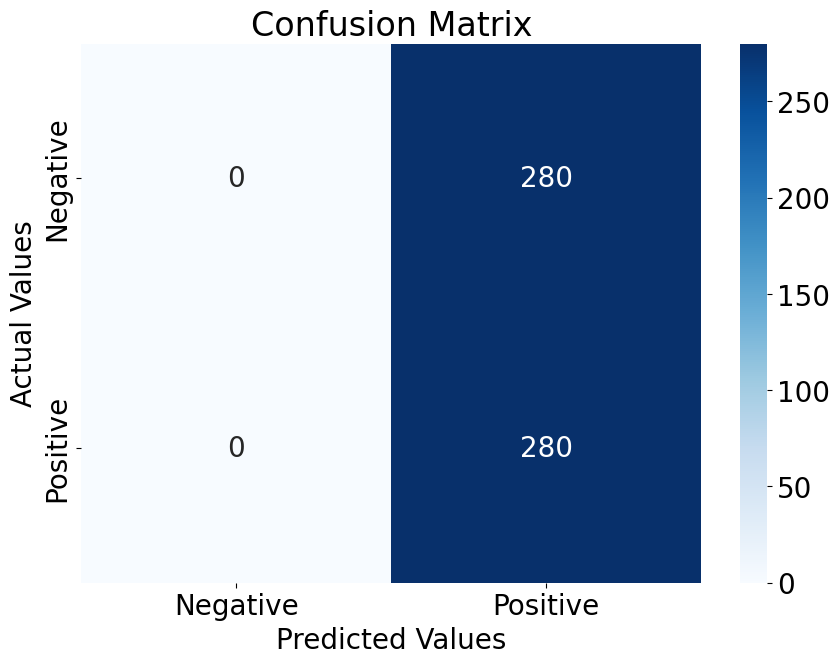

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true are your true labels and y_pred are your predicted labels
y_true = train_y
y_pred = train_pred

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [33]:
plot_confusion_matrix(y_true, y_pred, ["0", "1"])

TypeError: only integer scalar arrays can be converted to a scalar index